In [9]:
import os
import tensorflow as tf
import glob 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.summary.summary_iterator import summary_iterator

%matplotlib inline

figsize = (5.7, 3)
export_dir = os.path.join('./image')

sns.set_theme()
sns.set_context('paper')

def get_section_results(file):
    '''
    requires tensorflow==1.12.0
    '''
    X = []
    Y = []
    Z = []
    # To see the names of the tags, use tensorboard webui to open the log
    # command: tensorboard --logdir='path/to/your/log'
    for e in summary_iterator(file):
        for v in e.summary.value:
            if v.tag == 'Train_EnvstepsSoFar':
                X.append(v.simple_value)
            elif v.tag == 'Eval_AverageReturn':
                Y.append(v.simple_value)
            elif v.tag == 'Eval_StdReturn':
                Z.append(v.simple_value)
    return X, Y, Z

# Experiment 1

In [32]:
def read_q1_data(batch: str) -> pd.DataFrame():
    '''
    @param batch: str, should be 'sb'(small batch) or 'lb'(large batch)
    '''
    full_data = pd.DataFrame()

    for folder in os.listdir('data'):
        split = folder.split('_')
        if 'CartPole-v0' in split and batch in split:
            config_list = split[split.index(batch):split.index('CartPole-v0')]
            config = '_'.join(config_list)

            logdir = os.path.join('data', folder, 'events*')
            eventfile = glob.glob(logdir)[0]

            X, Y, Z = get_section_results(eventfile)
            # only data under current folder (3 folders each experiment)
            data = pd.DataFrame({
                'Iteration': range(len(X)),
                'Config': np.repeat(config, len(X)),
                'Train_EnvstepsSoFar': X,
                'Eval_AverageReturn': Y,
                'Eval_StdReturn': Z
            })
            data['Eval_AverageReturn_Smooth'] = data['Eval_AverageReturn'].ewm(alpha=0.6).mean()
            data['Eval_StdReturn'] = data['Eval_StdReturn'].ewm(alpha=0.6).mean()
            full_data = pd.concat([full_data, data], axis=0, ignore_index=True)
            
    return full_data

data_sb = read_q1_data('sb')
data_lb = read_q1_data('lb')
# data_batch_list = [data_sb, data_lb]

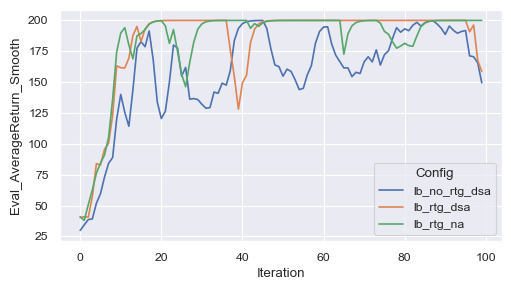

In [33]:
plt.figure(figsize=figsize)
sns.lineplot(data=data_lb, x='Iteration', y='Eval_AverageReturn_Smooth', hue='Config')
plt.savefig(os.path.join(export_dir, 'q1_lb.png'), dpi=200, bbox_inches='tight')

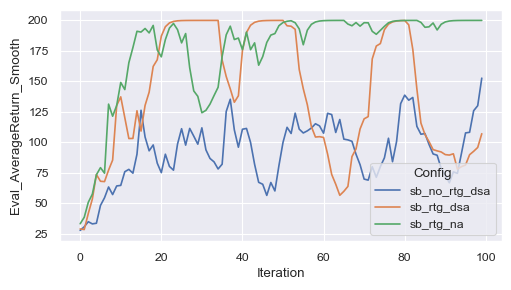

In [34]:
plt.figure(figsize=figsize)
sns.lineplot(data=data_sb, x='Iteration', y='Eval_AverageReturn_Smooth', hue='Config')
plt.savefig(os.path.join(export_dir, 'q1_sb.png'),dpi=200, bbox_inches='tight')

# Experiment 2